In [18]:
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne import Epochs, pick_types, events_from_annotations, concatenate_epochs
import scipy.signal
import matplotlib.pyplot as plt
import numpy as np


Using matplotlib backend: MacOSX
Extracting EDF parameters from /Users/leakimgilbert/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/leakimgilbert/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/leakimgilbert/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
Not setting metadata
Not setting metadata
90 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading 

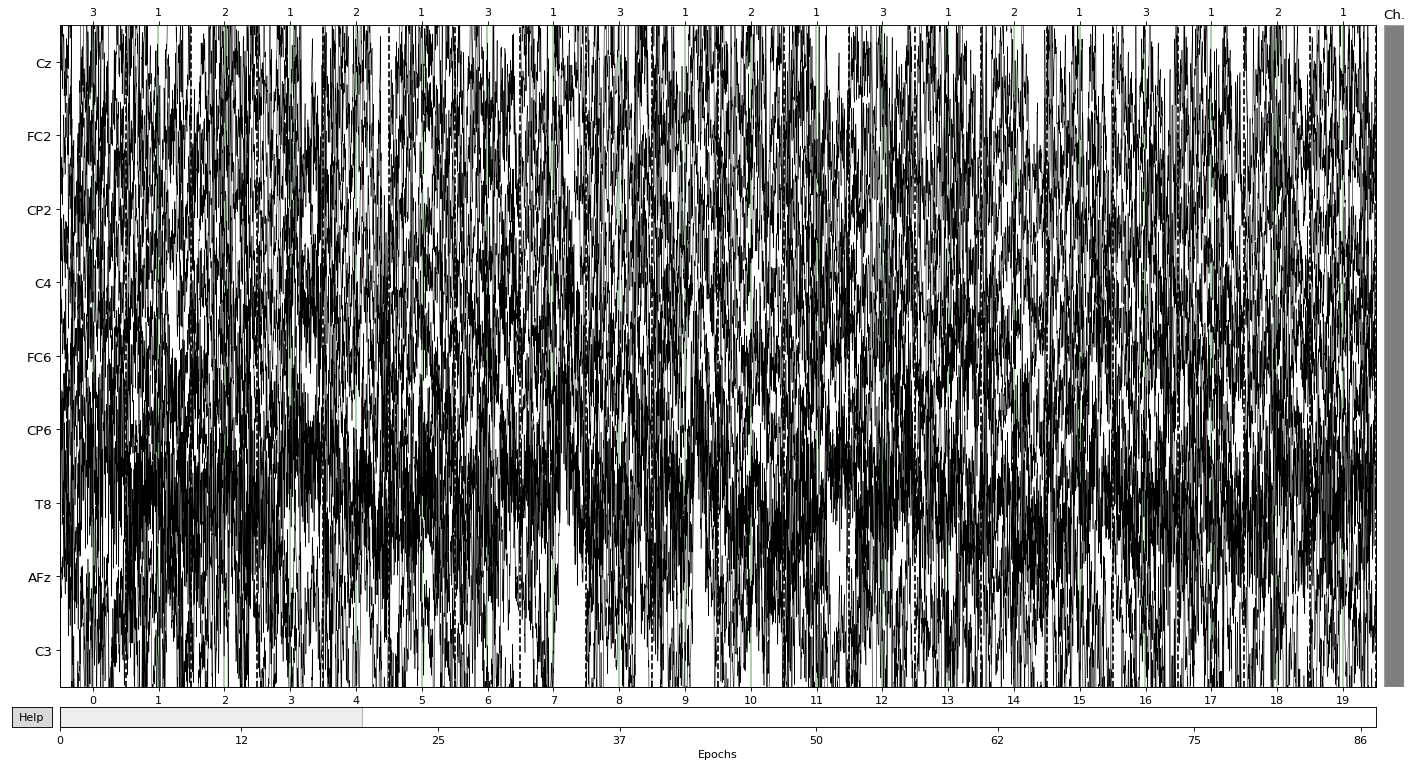

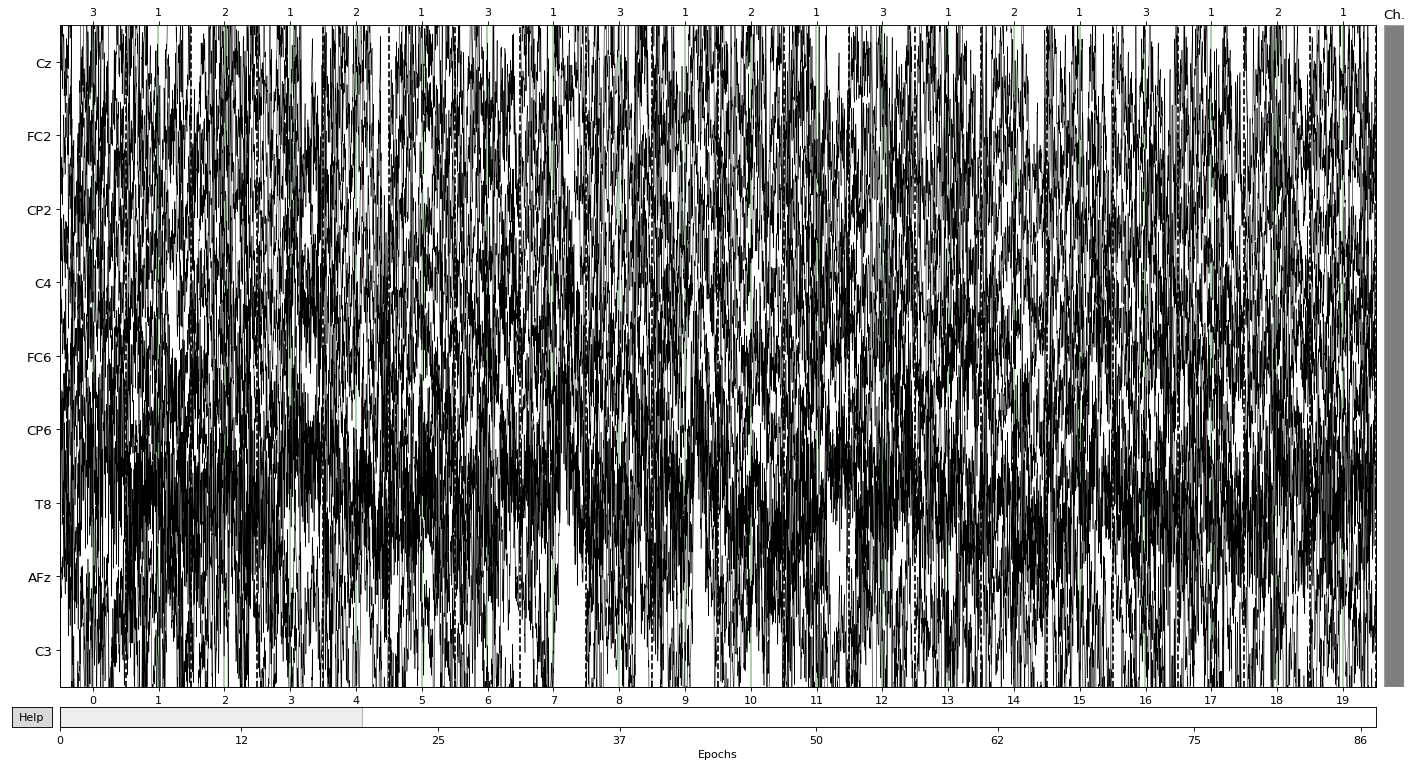

Dropped 0 epochs: 
Channels marked as bad: []


In [17]:
%matplotlib inline
subjects = [1]
runs = [4, 8, 12]
selected_channels = [10, 4, 18, 12, 6, 20, 41, 26, 8] # CZ, FC2, CP2, C4, FC6, CP6, T8, AFZ, C3 (reference)
EPOCH_DURATION = 2
tmin = -0.5 * EPOCH_DURATION
tmax = 0.5 * EPOCH_DURATION

event_id = { 
    'T0': 1,
    'T1': 2,
    'T2': 3
}

all_subjects_epochs = []

for subject in subjects:
    raw_filename = eegbci.load_data(subject, runs)
    raw_edf = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_filename])
    
    eegbci.standardize(raw_edf) # channels name
    raw_edf.rename_channels(lambda x: x.strip('.')) # remove dot from channel name
    
    raw_edf.pick(picks=selected_channels)
    events, annotations = events_from_annotations(raw_edf, event_id=event_id)
    epochs = Epochs(raw_edf, events=events, event_id=event_id, tmin=tmin, tmax=tmax, preload=True, detrend=None)
    all_subjects_epochs.append(epochs)

    print("Nb of events: ", len(raw_edf.annotations))
    print("Duration: ", set(raw_edf.annotations.duration))
    print("Description: ", set(raw_edf.annotations.description))
    print(raw_edf.annotations.onset)

# epochs = concatenate_epochs(all_subjects_epochs)


all_subjects_epochs.plot()

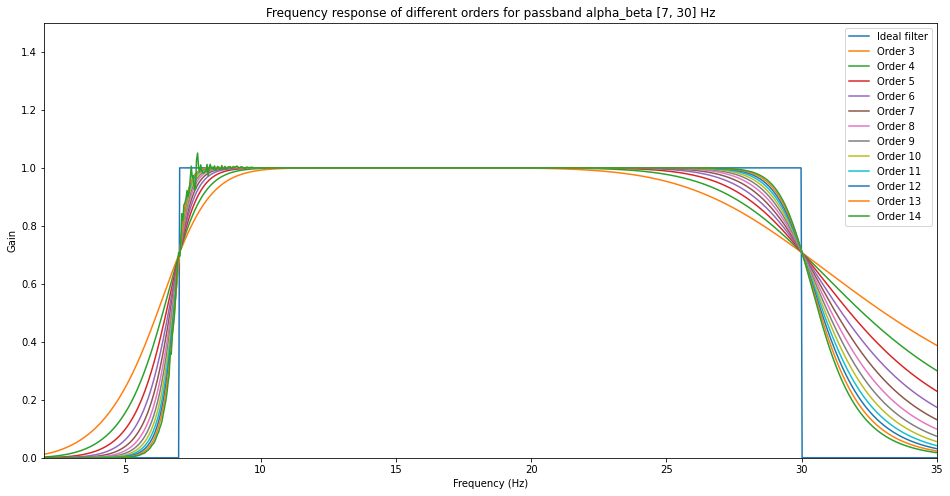

In [6]:
SAMPLING_FREQ = 160
NYQUIST_FREQ = SAMPLING_FREQ/2
WOR_N = 2056
FREQ_BANDS = {
    'alpha_beta': [7, 30],
}

epochs_sub_bands = dict.fromkeys(FREQ_BANDS.keys())
kernels = dict.fromkeys(FREQ_BANDS.keys())

for key, freq_range in FREQ_BANDS.items():
    fig, ax = plt.subplots(figsize = (16, 8))
    lower_bound = freq_range[0]/NYQUIST_FREQ
    upper_bound = freq_range[1]/NYQUIST_FREQ
    hz = np.linspace(0, NYQUIST_FREQ, WOR_N)
    ideal_filter = [1 if freq_range[0] <= f <= freq_range[1] else 0 for f in hz]
    ax.plot(hz, ideal_filter, label="Ideal filter")
    kernels[key] = {}
    for order in range(3,15):
        b, a = scipy.signal.butter(order, [lower_bound, upper_bound], btype='bandpass')
        w, h = scipy.signal.freqz(b, a, worN=WOR_N)
        ax.plot(hz, abs(h), label=f"Order {order}")
        ax.set_ylim([0, 1.5])
        ax.set_xlim([freq_range[0] - 5, freq_range[1] + 5])
        kernels[key][order] = (b, a)

    ax.legend()
    ax.set_title(f"Frequency response of different orders for passband {key} {freq_range} Hz")
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Gain")
    plt.show()

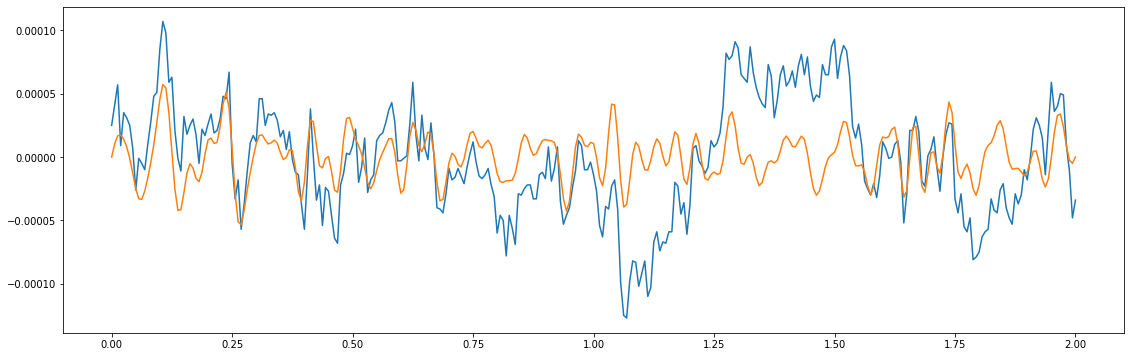

In [7]:
ORDERS = {
    'alpha_beta': 11,
}

for key, freq_range in FREQ_BANDS.items():
    l_freq = freq_range[0]/NYQUIST_FREQ
    h_freq = freq_range[1]/NYQUIST_FREQ
    b = kernels[key][ORDERS[key]][0]
    a = kernels[key][ORDERS[key]][1]
    epochs_sub_bands[key] = epochs.copy().filter(l_freq=l_freq, h_freq=h_freq, method='iir', n_jobs=-1, iir_params = {'order': order, 'ftype': 'butter','a': a,'b': b}, verbose=False)

fig, ax = plt.subplots(figsize=(19,6))

original_epoch = epochs['T0'][0].get_data().squeeze()[0]
x = np.linspace(0.0, EPOCH_DURATION, len(original_epoch))
ax.plot(x, original_epoch, label="Original signal")

reconstituted_signal = np.zeros(len(original_epoch))
for key in FREQ_BANDS.keys():
    reconstituted_signal += epochs_sub_bands[key]['T0'][0].get_data().squeeze()[0]

ax.plot(x, reconstituted_signal, label="Reconstituted signal")

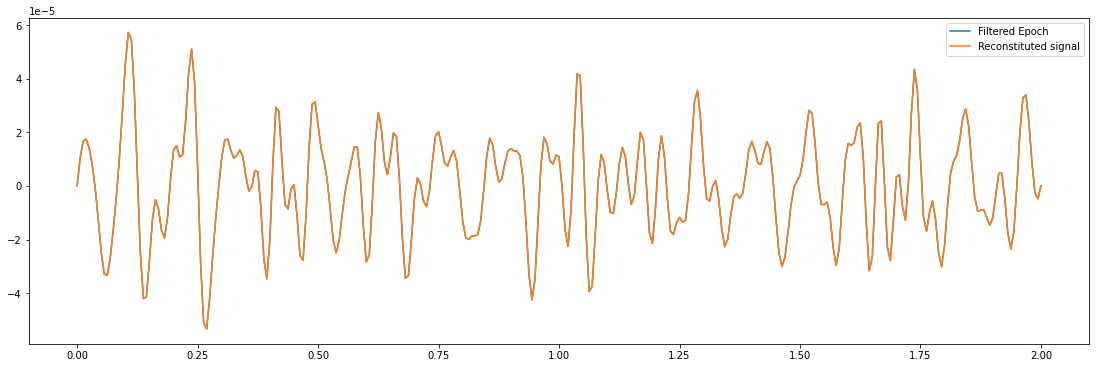

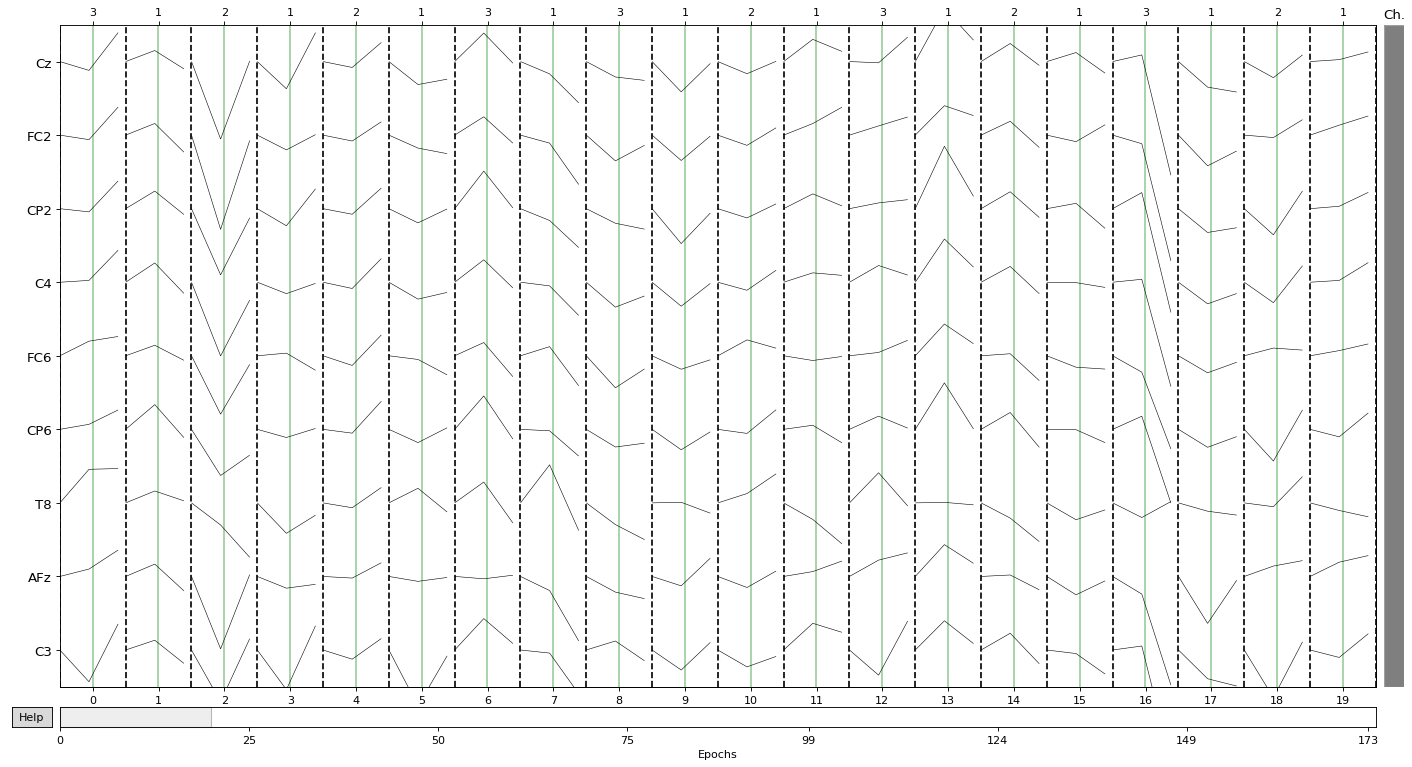

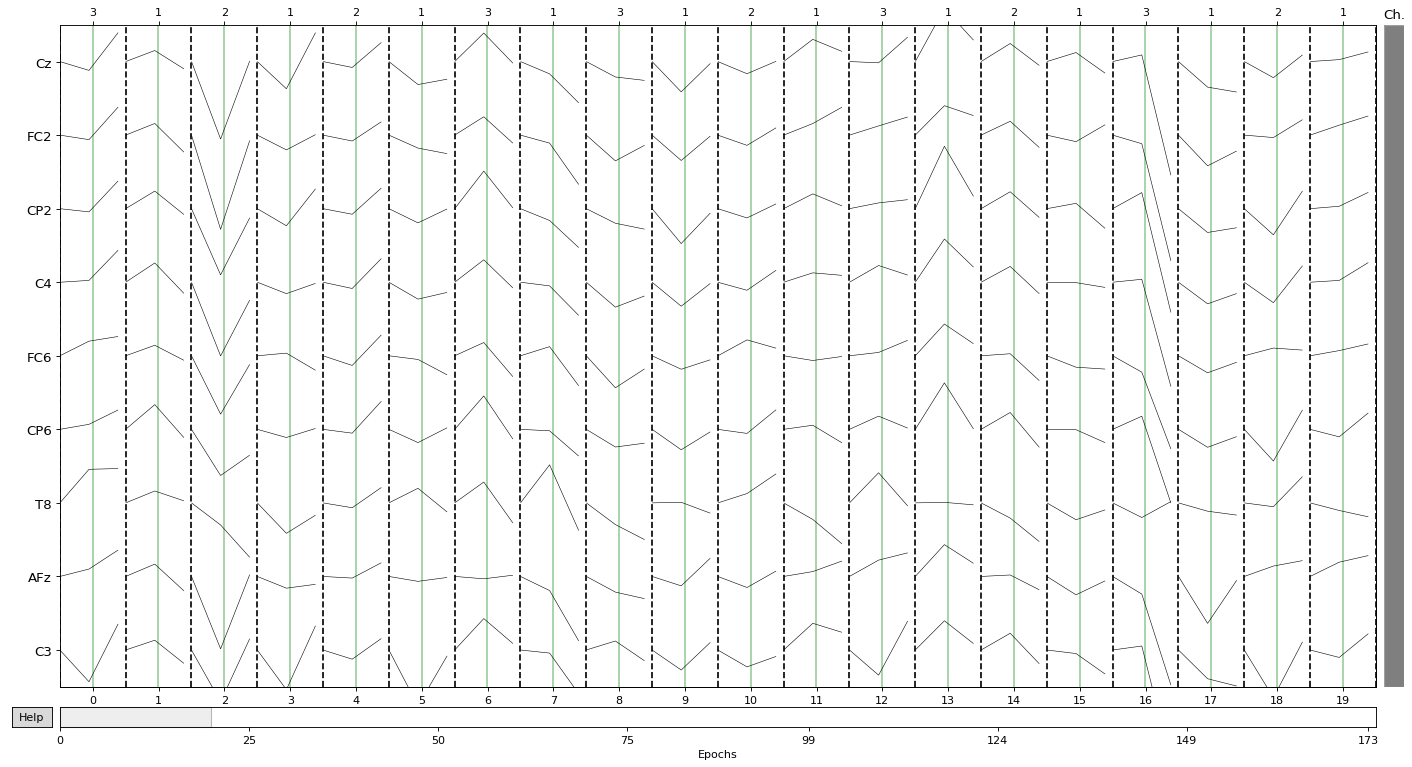

In [8]:
l_freq = FREQ_BANDS['alpha_beta'][0]/NYQUIST_FREQ
h_freq = FREQ_BANDS['alpha_beta'][1]/NYQUIST_FREQ
b = kernels['alpha_beta'][ORDERS['alpha_beta']][0]
a = kernels['alpha_beta'][ORDERS['alpha_beta']][1]
filtered_epochs = epochs.copy().filter(l_freq=l_freq, h_freq=h_freq, method='iir', n_jobs=-1, iir_params = {'order': ORDERS['alpha_beta'], 'ftype': 'butter','a': a,'b': b}, verbose=False)

fig, ax = plt.subplots(figsize=(19,6))
x = np.linspace(0.0, EPOCH_DURATION, len(original_epoch))

filtered_epoch = filtered_epochs['T0'][0].get_data().squeeze()[0]
ax.plot(x, filtered_epoch, label='Filtered Epoch')
ax.plot(x, reconstituted_signal, label="Reconstituted signal")
ax.legend()

filtered_epochs.plot()